In [1]:
import os
import time
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings 
warnings.filterwarnings('ignore')

In [2]:
train_dir = 'C:/Users/ADMIN/Downloads/seg_train.csv/seg_train'
test_dir = 'C:/Users/ADMIN/Downloads/seg_test.csv/seg_test'

In [3]:
classes = os.listdir(train_dir)
print("Classes: ",classes)

Classes:  ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [4]:
for cls in classes:
    print(f"{cls}: {len(os.listdir(os.path.join(train_dir, cls)))} images")  
total = sum(len(os.listdir(os.path.join(train_dir, cls))) for cls in classes)
print(f"Total images are {total}")

buildings: 2191 images
forest: 2271 images
glacier: 2404 images
mountain: 2512 images
sea: 2274 images
street: 2382 images
Total images are 14034


In [5]:
classes = os.listdir(train_dir)

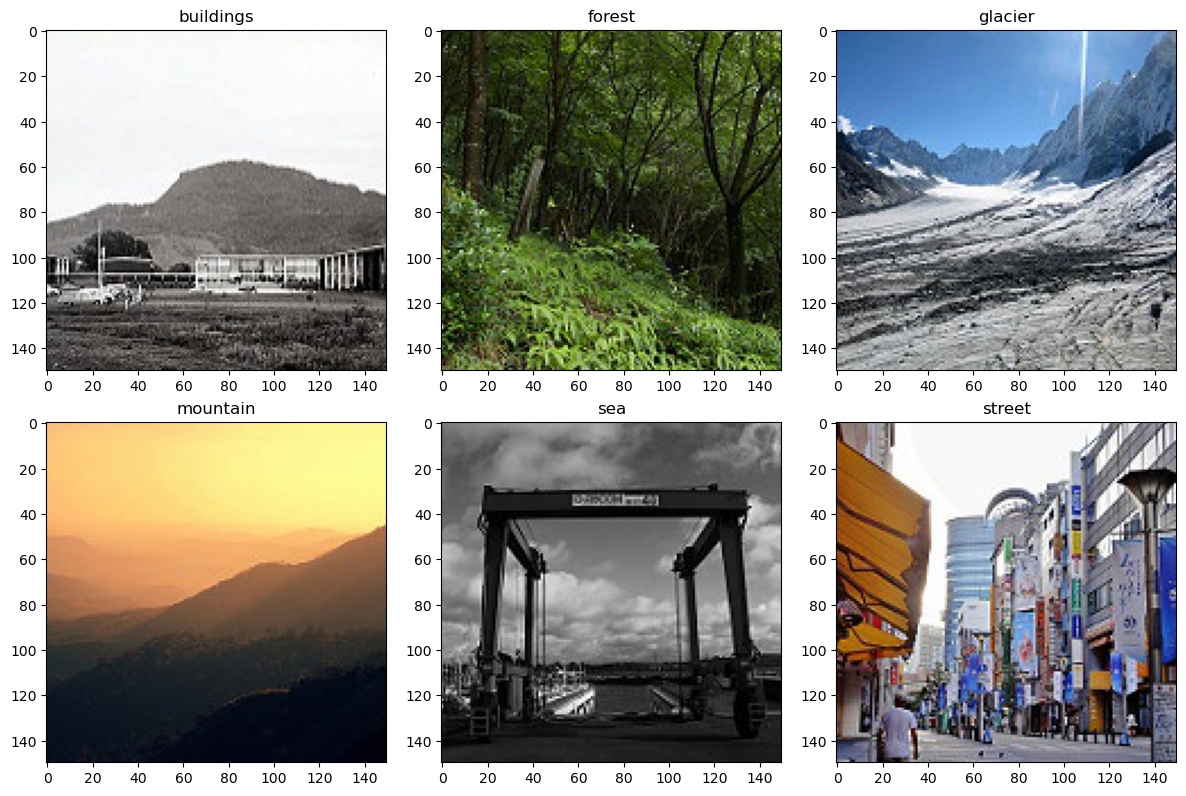

In [6]:
plt.figure(figsize=(12,8))
for i,cls in enumerate(classes):
    cls_path = os.path.join(train_dir,cls)
    img_path = os.path.join(cls_path,os.listdir(cls_path)[0])
    img = Image.open(img_path)
    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(cls)

plt.tight_layout()
plt.show()

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [8]:
img_size = (150,150)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale = 1./255,
    zoom_range = 0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode = 'nearest',
    validation_split = 0.2
)

test_datagen = ImageDataGenerator(
    rescale = 1./255
)

In [9]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'training'
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical',
    subset = 'validation'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [10]:
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size = img_size,
    shuffle = False,
    batch_size = batch_size,
    class_mode = 'categorical'
)

Found 3000 images belonging to 6 classes.


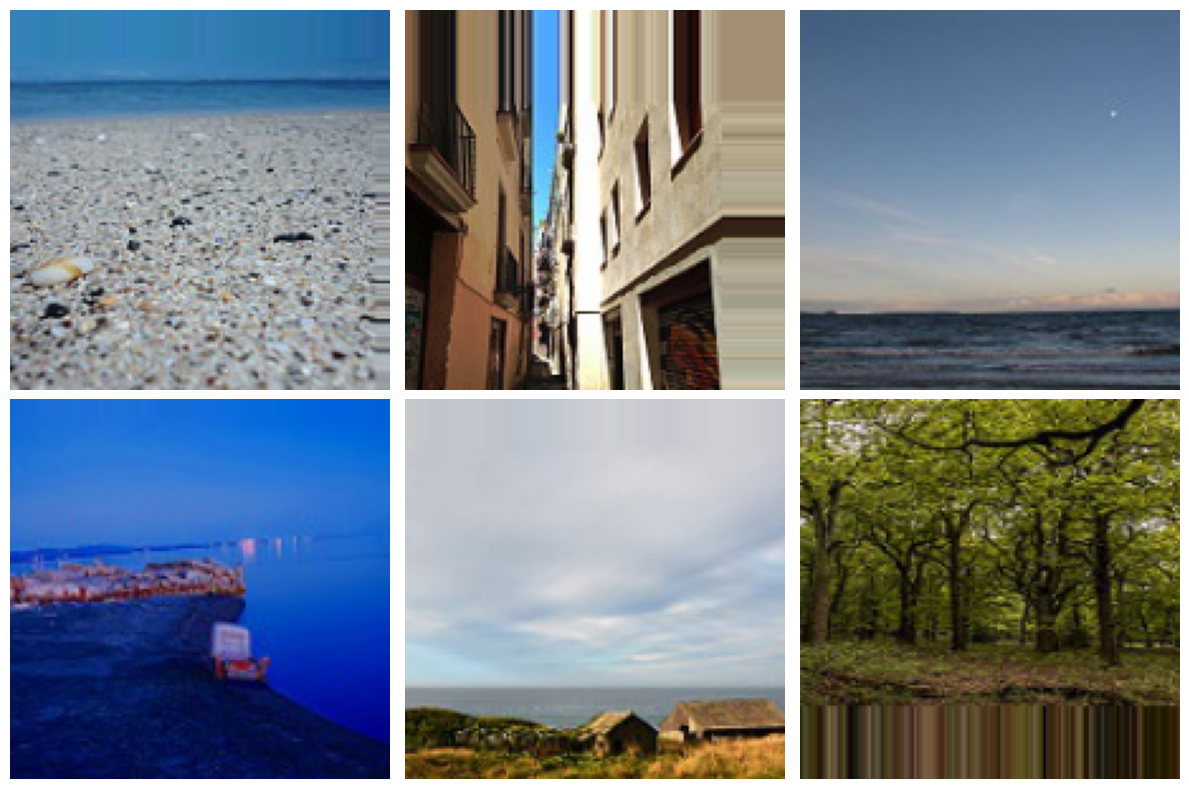

In [11]:
x_batch , y_batch = next(train_generator)

plt.figure(figsize=(12,8))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(x_batch[i])
    plt.axis('off')

plt.tight_layout()
plt.show()

In [12]:
x_batch.shape,y_batch.shape

((32, 150, 150, 3), (32, 6))

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Flatten,Dense,BatchNormalization,Dropout,Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau
import numpy as np

In [14]:
def cnn_model():
    model = Sequential([
        
    Conv2D(filters=128,kernel_size=(5,5),padding='valid',input_shape=(150,150,3)),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(filters=64,kernel_size=(3,3),padding='valid'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Conv2D(filters=32,kernel_size=(3,3),padding='valid'),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    BatchNormalization(),

    Flatten(), 
    Dense(128,activation='relu'),
    Dropout(0.2),
    Dense(6,activation='softmax'),
    
])
    return model

In [15]:
cnn_model = cnn_model()

In [16]:
print(cnn_model.summary())

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 146, 146, 128)       │           9,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 146, 146, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 73, 73, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 73, 73, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 71, 71, 64)          │          73,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 71, 71, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 35, 35, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 35, 35, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 33, 33, 32)          │          18,464 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 33, 33, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       1,048,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             774 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,152,358 (4.40 MB)

 Trainable params: 1,151,910 (4.39 MB)

 Non-trainable params: 448 (1.75 KB)

None


In [17]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor = np.sqrt(0.1),
    patience = 10,
    verbose=2
)

In [18]:
cnn_model.compile(optimizer=Adam(learning_rate=0.01),loss='categorical_crossentropy',metrics=['accuracy'])

In [19]:
history = cnn_model.fit(
    train_generator,
    steps_per_epoch = train_generator.samples // batch_size,
    epochs=3,
    validation_data=validation_generator,
    validation_steps = validation_generator.samples // batch_size,
    callbacks = [reduce_lr]
)

Epoch 1/3
350/350 ━━━━━━━━━━━━━━━━━━━━ 460s 1s/step - accuracy: 0.3262 - loss: 8.4045 - val_accuracy: 0.4404 - val_loss: 1.4022 - learning_rate: 0.0100
Epoch 2/3
350/350 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.4062 - loss: 1.4978 - val_accuracy: 0.4077 - val_loss: 1.4284 - learning_rate: 0.0100
Epoch 3/3
350/350 ━━━━━━━━━━━━━━━━━━━━ 532s 2s/step - accuracy: 0.4426 - loss: 1.3681 - val_accuracy: 0.3743 - val_loss: 1.3901 - learning_rate: 0.0100
